# Unsupervised Image retrieval

## Unsupervised Image retrieval

In [1]:
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

C:\Program Files (x86)\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the training data

In [4]:
(X_train, _),(X_test, _) = mnist.load_data()

## Normalize the data

In [5]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

## Reshape the data to have 1 channel

In [6]:
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))

In [8]:
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


## Create the autoencoder

In [9]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

## Train it

In [10]:
autoencoder.fit(X_train, X_train, epochs=2, batch_size=32, callbacks=None )

Epoch 1/2
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1127
Epoch 2/2
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1120


In [11]:
autoencoder.save('autoencoder.h5')

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0         
__________

## Create the encoder part

The encoder part is the first half of the autoencoder, i.e. the part that will encode the input into a latent space representation. In this case, the dimension of this representation is $4 \times 4 \times 8$

In [13]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [15]:
encoder.save('encoder.h5')

## Load the query image

We take a query image from the test set

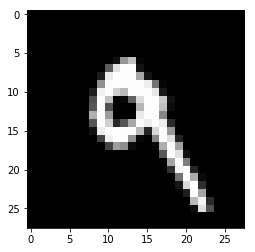

In [16]:
query = X_test[7]
plt.imshow(query.reshape(28,28), cmap='gray')

## Encode the test images and the query image

In [17]:
X_test.shape

(10000, 28, 28, 1)

We remove the query image from the test set (the set in which we will search for close images)

In [18]:
X_test = np.delete(X_test, 7, axis=0)

In [19]:
X_test.shape

(9999, 28, 28, 1)

### Encode the query image and the test set

In [20]:
codes = encoder.predict(X_test)
query_code = encoder.predict(query.reshape(1,28,28,1))
codes.shape

(9999, 4, 4, 8)

In [21]:
query_code.shape

(1, 4, 4, 8)

## Find the closest images

In [22]:
from sklearn.neighbors import NearestNeighbors

We will find the 5 closest images

In [27]:
n_neigh = 10
codes = codes.reshape(-1, 4*4*8); print(codes.shape)
query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)

(9999, 128)
(1, 128)


### Fit the KNN to the test set

In [28]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)
distances, indices = nbrs.kneighbors(np.array(query_code))
closest_images = X_test[indices]
closest_images = closest_images.reshape(-1,28,28,1); print(closest_images.shape)

(10, 28, 28, 1)


## Get the closest images

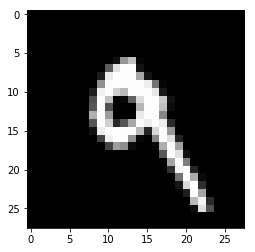

In [29]:
plt.imshow(query.reshape(28,28), cmap='gray')

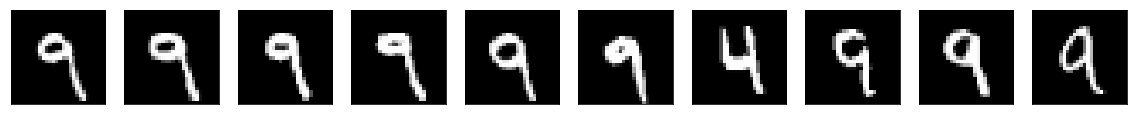

In [30]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()